In [163]:
#These free use functions were made for python based on the original 2003 paper that invented
#The consensus clustering algorithm. Scroll to next block for project code

###############################################
# Copyright Žiga Sajovic, XLAB 2019           #
# Distributed under the MIT License           #
#                                             #
# github.com/ZigaSajovic/Consensus_Clustering #
#                                             #
###############################################

import numpy as np
from itertools import combinations
import bisect

##My imports
import matplotlib.pyplot as plt 
from scipy import stats
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,pairwise_distances_argmin, pairwise_distances, jaccard_score
import seaborn as sns


class ConsensusCluster:
    """
      Implementation of Consensus clustering, following the paper
      https://link.springer.com/content/pdf/10.1023%2FA%3A1023949509487.pdf
      Args:
        * cluster -> clustering class
        * NOTE: the class is to be instantiated with parameter `n_clusters`,
          and possess a `fit_predict` method, which is invoked on data.
        * L -> smallest number of clusters to try
        * K -> biggest number of clusters to try
        * H -> number of resamplings for each cluster number
        * resample_proportion -> percentage to sample
        * Mk -> consensus matrices for each k (shape =(K,data.shape[0],data.shape[0]))
                (NOTE: every consensus matrix is retained, like specified in the paper)
        * Ak -> area under CDF for each number of clusters 
                (see paper: section 3.3.1. Consensus distribution.)
        * deltaK -> changes in areas under CDF
                (see paper: section 3.3.1. Consensus distribution.)
        * self.bestK -> number of clusters that was found to be best
      """

    def __init__(self, cluster, L, K, H, resample_proportion=0.5):
        assert 0 <= resample_proportion <= 1, "proportion has to be between 0 and 1"
        self.cluster_ = cluster
        self.resample_proportion_ = resample_proportion
        self.L_ = L
        self.K_ = K
        self.H_ = H
        self.Mk = None
        self.Ak = None
        self.deltaK = None
        self.bestK = None

    def _internal_resample(self, data, proportion):
        """
        Args:
          * data -> (examples,attributes) format
          * proportion -> percentage to sample
        """
        resampled_indices = np.random.choice(
            range(data.shape[0]), size=int(data.shape[0]*proportion), replace=False)
        data = data.loc[resampled_indices,:]
        return resampled_indices, data

    def fit(self, data, verbose=False):
        """
        Fits a consensus matrix for each number of clusters

        Args:
          * data -> (examples,attributes) format
          * verbose -> should print or not
        """
        Mk = np.zeros((self.K_-self.L_, data.shape[0], data.shape[0]))
        Is = np.zeros((data.shape[0],)*2)
        for k in range(self.L_, self.K_):  # for each number of clusters
            i_ = k-self.L_
            if verbose:
                print("At k = %d, aka. iteration = %d" % (k, i_))
            for h in range(self.H_):  # resample H times
                if verbose:
                    print("\tAt resampling h = %d, (k = %d)" % (h, k))
                resampled_indices, resample_data = self._internal_resample(self,data=data,proportion=self.resample_proportion_)
                Mh = self.cluster_(n_clusters=k).fit_predict(resample_data)
                # find indexes of elements from same clusters with bisection
                # on sorted array => this is more efficient than brute force search
                index_mapping = np.array((Mh, resampled_indices)).T
                index_mapping = index_mapping[index_mapping[:, 0].argsort()]
                sorted_ = index_mapping[:, 0]
                id_clusts = index_mapping[:, 1]
                for i in range(k):  # for each cluster
                    ia = bisect.bisect_left(sorted_, i)
                    ib = bisect.bisect_right(sorted_, i)
                    is_ = id_clusts[ia:ib]
                    ids_ = np.array(list(combinations(is_, 2))).T
                    # sometimes only one element is in a cluster (no combinations)
                    if ids_.size != 0:
                        Mk[i_, ids_[0], ids_[1]] += 1
                # increment counts
                ids_2 = np.array(list(combinations(resampled_indices, 2))).T
                Is[ids_2[0], ids_2[1]] += 1
            Mk[i_] /= Is+1e-8  # consensus matrix
            # Mk[i_] is upper triangular (with zeros on diagonal), we now make it symmetric
            Mk[i_] += Mk[i_].T
            Mk[i_, range(data.shape[0]), range(
                data.shape[0])] = 1  # always with self
            Is.fill(0)  # reset counter
        self.Mk = Mk
        # fits areas under the CDFs
        self.Ak = np.zeros(self.K_-self.L_)
        for i, m in enumerate(Mk):
            hist, bins = np.histogram(m.ravel(), density=True)
            self.Ak[i] = sum((h*(b-a))
                             for b, a, h in zip(bins[1:], bins[:-1], np.cumsum(hist)))
        # fits differences between areas under CDFs
        self.deltaK = np.array([(Ab-Aa)/Aa if i > 2 else Aa
                                for Ab, Aa, i in zip(self.Ak[1:], self.Ak[:-1], range(self.L_, self.K_-1))])
        self.bestK = np.argmax(self.deltaK) + \
            self.L_ if self.deltaK.size > 0 else self.L_

    def predict(self):
        """
        Predicts on the consensus matrix, for best found cluster number
        """
        assert self.Mk is not None, "First run fit"
        return self.cluster_(n_clusters=self.bestK).fit_predict(
            1-self.Mk[self.bestK-self.L_])

    def predict_data(self, data):
        """
        Predicts on the data, for best found cluster number
        Args:
          * data -> (examples,attributes) format 
        """
        assert self.Mk is not None, "First run fit"
        return self.cluster_(n_clusters=self.bestK).fit_predict(
            data)


The best K value is: 3


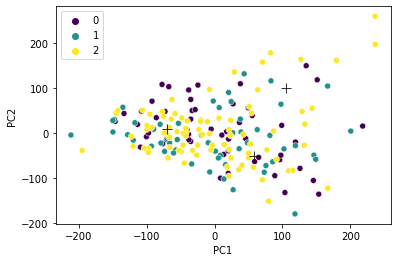

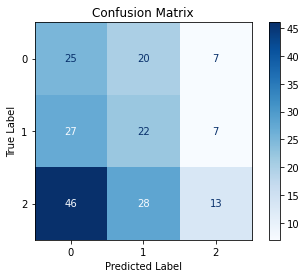

Jaccard Score: 0.1800837776085301


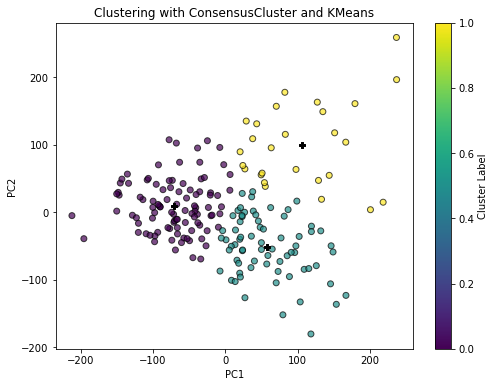

In [173]:
#New Code Starts Here
gse20680_pca = pd.read_csv("GSE20680_scaled_projected.csv")

data = (gse20680_pca.loc[:,['PC1', 'PC2']])
self = ConsensusCluster

#Consensus Clustering
ConsensusCluster.__init__(self, KMeans, 3, 10, 100, 0.5)
gse20680_cluster = ConsensusCluster.fit(self, data, verbose=False)
gse20680_labels = ConsensusCluster.predict_data(self,data)
bestK = self.bestK
print("The best K value is: " + str(bestK))

#Plot centers and results with k centers  
gse20680_kmeans = KMeans(n_clusters=bestK, random_state=0).fit(gse20680_pca.loc[:,['PC1', 'PC2']])
sns.scatterplot(x = gse20680_pca_clusters['PC1'],
                y = gse20680_pca_clusters['PC2'],
                hue=gse20680_pca_clusters['cad_status'],
                palette='viridis')
sns.scatterplot(x=gse20680_kmeans.cluster_centers_[:, 0],
                y=gse20680_kmeans.cluster_centers_[:, 1],
                s=100,
                marker = "+",
                color = "black")

#Plot confusion matrix and Jaccard
gse20680_pca_clusters['cad_status'].replace({'Control (0)': 0, 'Intermediate (1)': 1, 'Case (2)':2}, inplace=True)
conf_matrix = confusion_matrix(gse20680_pca_clusters['cad_status'], gse20680_labels)  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(len(conf_matrix)))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
jaccard = jaccard_score(gse20680_pca_clusters['cad_status'], gse20680_labels, average='macro')   
print("Jaccard Score:", jaccard)
plt.show()

#Plot with predicted labels and centers
plt.figure(figsize=(8, 6))
plt.scatter(data['PC1'], data['PC2'], c=gse20680_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.scatter(gse20680_kmeans.cluster_centers_[:, 0],gse20680_kmeans.cluster_centers_[:, 1],c="black",marker= "P")
plt.title('Clustering with ConsensusCluster and KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Label')
plt.show()

The best K value is:2


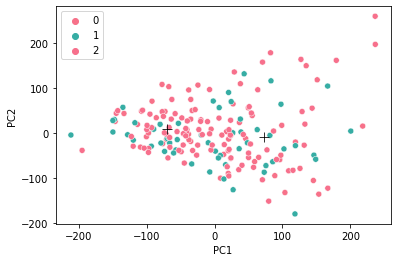

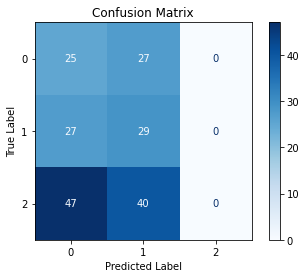

Jaccard Score: 0.14472835204542522


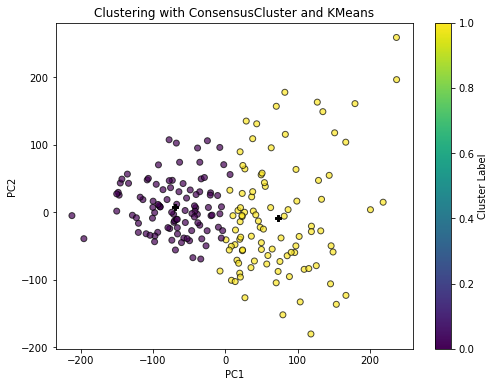

In [172]:
ConsensusCluster.__init__(self, KMeans, 2, 10, 100, 0.5)
gse20680_cluster = ConsensusCluster.fit(self, data, verbose=False)
gse20680_labels = ConsensusCluster.predict_data(self,data)
bestK = self.bestK
print("The best K value is:" + str(bestK))

gse20680_kmeans = KMeans(n_clusters=bestK, random_state=0).fit(gse20680_pca.loc[:,['PC1', 'PC2']])
sns.scatterplot(x = gse20680_pca_clusters['PC1'],
                y = gse20680_pca_clusters['PC2'],
                hue=gse20680_pca_clusters['cad_status'],
                palette='husl')
sns.scatterplot(x=gse20680_kmeans.cluster_centers_[:, 0],
                y=gse20680_kmeans.cluster_centers_[:, 1],
                s=100,
                marker = "+",
                color = "black")

gse20680_pca_clusters['cad_status'].replace({'Control (0)': 0, 'Intermediate (1)': 1, 'Case (2)':2}, inplace=True)
conf_matrix = confusion_matrix(gse20680_pca_clusters['cad_status'], gse20680_labels)  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(len(conf_matrix)))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

jaccard = jaccard_score(gse20680_pca_clusters['cad_status'], gse20680_labels, average='macro')  
print("Jaccard Score:", jaccard)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(data['PC1'], data['PC2'], c=gse20680_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.scatter(gse20680_kmeans.cluster_centers_[:, 0],gse20680_kmeans.cluster_centers_[:, 1],c="black",marker= "P")
plt.title('Clustering with ConsensusCluster and KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Label')
plt.show()